<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 39 - Why Hedge?
***

# Why You Should Hedge Beta and Sector Exposures

by Jonathan Larkin and Maxwell Margenot


Whenever we have a trading strategy of any sort, we need to be considering the impact of systematic risk. There needs to be some risk involved in a strategy in order for there to be a return above the risk-free rate, but systematic risk poisons the well, so to speak. By its nature, systematic risk provides a commonality between the many securities in the market that cannot be diversified away. As such, we need to construct a hedge to get rid of it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import seaborn as sns
import statsmodels.api as sm

## The Fundamental Law of Asset Management

The primary driver of the value of any strategy is whether or not it provides a compelling risk-adjusted return, i.e., the Sharpe Ratio. As expressed in "The Fundamental Law of Active Management", by Richard Grinold, Sharpe Ratio can be decomposed into two components, skill and breadth, as:

$$IR = IC \sqrt{BR}$$

Technically, this is the definition of the Information Ratio (IR), but for our purposes it is equivalent to the Sharpe Ratio. The IR is the ratio of the excess return of a portfolio over its benchmark per unit active risk, i.e., the excess return of a long-only portfolio less its benchmark per unit tracking error. In the time of Grinold’s publication, however, long/short investing was a rarity. Today, in the world of hedge funds and long/short investing, there is no benchmark. We seek absolute returns so, in this case, the IR is equivalent to the Sharpe ratio.

In this equation, skill is measured by IC (Information Coefficient), calculated with Alphalens. The IC is essentially the Spearman rank correlation, used to correlate your prediction and its realization. Breadth is measured as the number of **independent** bets in the period. The takeaway from this "law" is that, with any strategy, we need to:

1. Bet well (high IC),
2. Bet often (high number of bets), *and*
3. **Make independent bets**

If the bets are completely independent, then breadth is the total number of bets we have made for every individual asset, the number of assets times the number of periods. If the bets are not independent then the **effective breadth** can be much much less than the number of assets. Let's see precisely what beta exposure and sector exposure do to **effective breadth**.

<div class="alert alert-warning">
<b>TL;DR:</b> Beta exposure and sector exposure lead to a significant increase in correlation among bets. Portfolios with beta and sector bets have very low effective breadth. In order to have high Sharpe then, these portfolios must have very high IC. It is easier to increase effective breadth by hedging beta and sector exposure than it is to increase your IC.
</div>

## Forecasts and Bet Correlation

We define a bet as the forecast of the *residual* of a security return. This forecast can be implicit -- i.e., we buy a stock and thus implicity we forecast that the stock will go up. What though do we mean by *residual*? Without any fancy math, this simply means the return **less a hedge**. Let's work through three examples. We use the Ledoit-Wolf covariance estimator to assess our covariance in all cases. For more information on why we use Ledoit-Wolf instead of typical sample covariance, check out the Estimating Covariance Matrices lecture.

### Example 1: No Hedge!

If we go long on a set of securities, but do not hold any short positions, there is no hedge! So the *residual* is the stock return itself.

$$r_{resid,i} = r_i$$

Let's see what the correlation of our bets are in this case.

In [2]:
from quantrocket.master import get_securities
from quantrocket import get_prices

tickers = ['WFC', 'JPM', 'USB', 'XOM', 'BHI', 'SLB'] # The securities we want to go long on
securities = get_securities(symbols=tickers, vendors='usstock')

# Obtain prices
historical_prices = get_prices(
    'usstock-learn-1d', 
    data_frequency='daily', 
    sids=securities.index.tolist(), 
    start_date='2009-01-01',
    end_date='2011-02-22',
    fields='Close')

sids_to_symbols = securities.Symbol.to_dict()
historical_prices = historical_prices.rename(columns=sids_to_symbols)

rets = historical_prices.loc['Close'].pct_change().fillna(0) # Calculate returns
lw_cov = LedoitWolf().fit(rets).covariance_ # Calculate Ledoit-Wolf estimator

def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

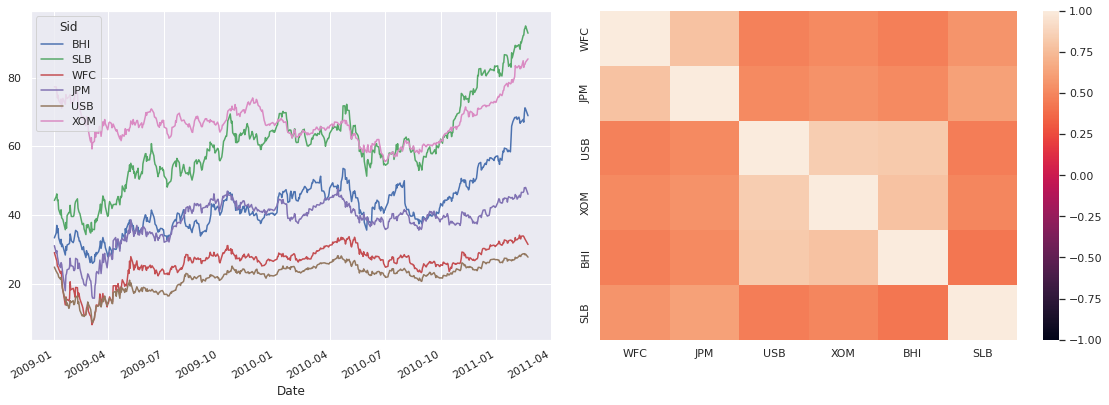

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
# Plot prices
left = historical_prices.loc['Close'].plot(ax=ax1)
# Plot covariance as a heat map
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers)

In [4]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.5876


The result here is that we have six bets and they are all very highly correlated.

### Example 2: Beta Hedge

In this case, we will assume that each bet is hedged against the market (SPY). In this case, the residual is calculated as:

$$ r_{resid,i} = r_i - \beta_i r_i $$

where $\beta_i$ is the beta to the market of security $i$ calculated with the CAPM and $r_i$ is the return of security $i$.

In [5]:
tickers = ['WFC', 'JPM', 'USB', 'XOM', 'BHI', 'SLB', 'SPY'] # The securities we want to go long on
securities = get_securities(symbols=tickers, vendors='usstock')

# Obtain prices
historical_prices = get_prices(
    'usstock-learn-1d', 
    data_frequency='daily', 
    sids=securities.index.tolist(), 
    start_date='2009-01-01',
    end_date='2011-02-22',
    fields='Close')

sids_to_symbols = securities.Symbol.to_dict()
historical_prices = historical_prices.rename(columns=sids_to_symbols)

rets = historical_prices.loc['Close'].pct_change().fillna(0) # Calculate returns

market = rets['SPY']
stock_rets = rets.drop('SPY', axis=1)
residuals = stock_rets.copy()*0

for stock in stock_rets.columns:
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    residuals[stock] = results.resid

lw_cov = LedoitWolf().fit(residuals).covariance_ # Calculate Ledoit-Wolf Estimator

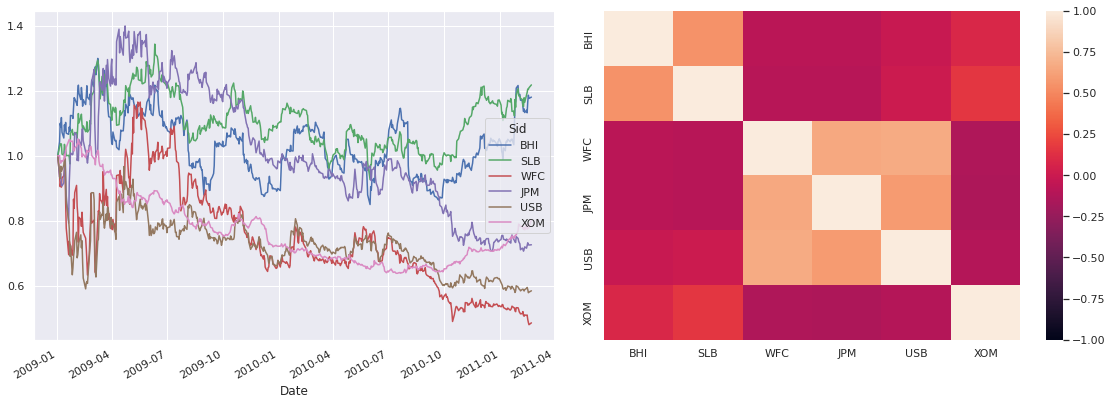

In [6]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=stock_rets.columns, yticklabels=stock_rets.columns)

In [7]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.1290


The beta hedge has brought down the average correlation significanty. Theoretically, this should improve our breadth. It is obvious that we are left with two highly correlated clusters however. Let's see what happens when we hedge the sector risk.

### Example 3: Sector Hedge

The sector return and the market return are themselves highly correlated. As such, you cannot do a multivariate regression due to multicollinearity, a classic violation of regression assumptions (see the lecture "Violations of Regression Models"). To hedge against both the market and a given security's sector, you first estimate the market beta residuals and then calculate the sector beta on *those* residuals.

$$
r_{resid,i} = r_i - \beta_i r_i \\
r_{resid_{SECTOR},i}= r_{resid,i} - \beta_{SECTOR,i}r_{resid,i}
$$

Here, $r_{resid, i}$ is the residual between the security return and a market beta hedge and $r_{resid_{SECTOR}, i}$ is the residual between *that* residual and a hedge of that residual against the relevant sector.

In [8]:
tickers = ['WFC', 'JPM', 'USB', 'XLF', 'SPY', 'XOM', 'BHI', 'SLB', 'XLE']
securities = get_securities(symbols=tickers, vendors='usstock')

# Obtain prices
historical_prices = get_prices(
    'usstock-learn-1d', 
    data_frequency='daily', 
    sids=securities.index.tolist(), 
    start_date='2009-01-01',
    end_date='2011-02-22',
    fields='Close')

sids_to_symbols = securities.Symbol.to_dict()
historical_prices = historical_prices.rename(columns=sids_to_symbols)

rets = historical_prices.loc['Close'].pct_change().fillna(0) # Calculate returns

# Get market hedge ticker
mkt = 'SPY'
# Get sector hedge tickers
sector_1_hedge = 'XLF'
sector_2_hedge = 'XLE'
# Identify securities for each sector
sector_1_stocks = ['WFC', 'JPM', 'USB']
sector_2_stocks = ['XOM', 'BHI', 'SLB']

market_rets = rets[mkt]
sector_1_rets = rets[sector_1_hedge]
sector_2_rets = rets[sector_2_hedge]
                           
stock_rets = rets.drop(['XLF', 'SPY', 'XLE'], axis=1)
residuals_market = stock_rets.copy()*0
residuals = stock_rets.copy()*0
# Calculate market beta of sector 1 benchmark
model = sm.OLS(sector_1_rets.values, market.values)
results = model.fit()
sector_1_excess = results.resid
# Calculate market beta of sector 2 benchmark
model = sm.OLS(sector_2_rets.values, market.values)
results = model.fit()
sector_2_excess = results.resid

for stock in sector_1_stocks:
    # Calculate market betas for sector 1 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_1_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid
                           
for stock in sector_2_stocks:
    # Calculate market betas for sector 2 stocks
    model = sm.OLS(stock_rets[stock], market.values)
    results = model.fit()
    # Calculate residual of security + market hedge
    residuals_market[stock] = results.resid
    # Calculate sector beta for previous residuals
    model = sm.OLS(residuals_market[stock], sector_2_excess)
    results = model.fit()
    # Get final residual
    residuals[stock] = results.resid

# Get covariance of residuals
lw_cov = LedoitWolf().fit(residuals).covariance_

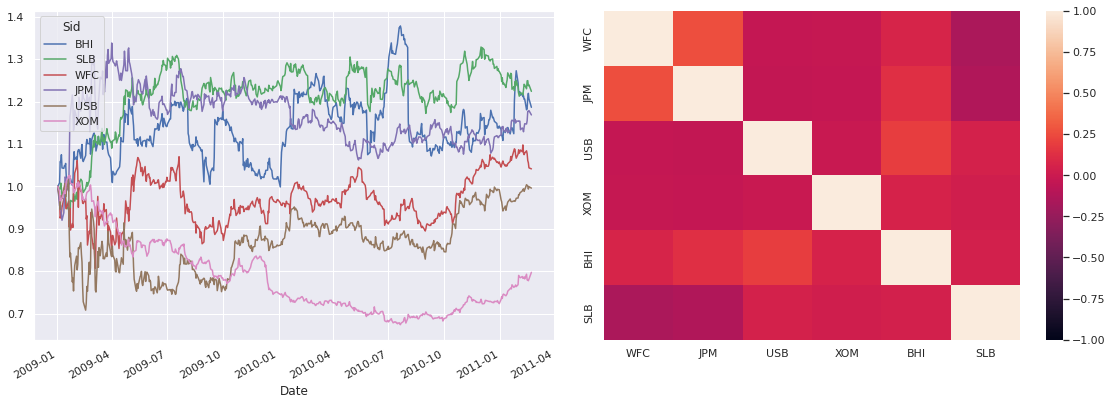

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.tight_layout()

corr = extract_corr_from_cov(lw_cov)
left = (1+residuals).cumprod().plot(ax=ax1)
labels = sector_1_stocks + sector_2_stocks
right = sns.heatmap(corr, ax=ax2, fmt='d', vmin=-1, vmax=1, xticklabels=labels, yticklabels=labels)

In [10]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print('Average pairwise correlation: %.4f' % average_corr)

Average pairwise correlation: 0.0275


The sector hedge further brought down the correlation between our bets. 

## Calculating Effective Breadth

This section is based on "How to calculate breadth: An evolution of the fundamental law of active portfolio management", by David Buckle; Vol. 4, 6, 393-405, 2003, _Journal of Asset Management_. Buckle derives the "semi-generalised fundamental law of active management" under several weak assumptions. The key result of this paper (for us) is a closed-form calculaiton of effective breadth as a function of the correlation between bets. Buckle shows that breadth, $BR$, can be modeled as

$$BR = \frac{N}{1 + \rho(N -1)}$$

where N is the number of stocks in the portfolio and $\rho$ is the assumed single correlation of the expected variation around the forecast.

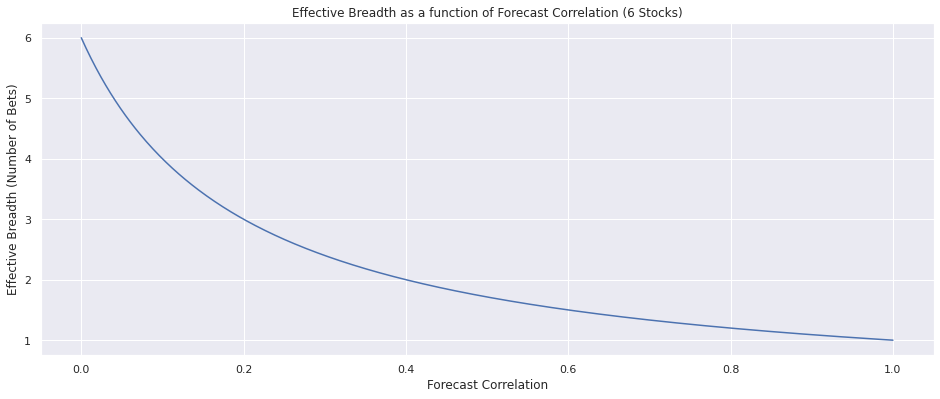

In [11]:
def buckle_BR_const(N, rho):
    return N/(1 + rho*(N - 1))

corr = np.linspace(start=0, stop=1.0, num=500)
plt.plot(corr, buckle_BR_const(6, corr))
plt.title('Effective Breadth as a function of Forecast Correlation (6 Stocks)')
plt.ylabel('Effective Breadth (Number of Bets)')
plt.xlabel('Forecast Correlation');

Here we see that in the case of the long-only portfolio, where the average correlation is 0.56, we are *effectively making only approximately 2 bets*. When we hedge beta, with a resulting average correlation of 0.22, things get a little better, *three effective bets*. When we add the sector hedge, we get close to zero correlation, and in this case the number of bets equals the number of assets, 6.

**More independent bets with the same IC leads to higher Sharpe ratio.**

## Using this in Practice

Trading costs money due to market impact and commissions. As such, the post hoc implementation of a hedge is almost always suboptimal. In that case, you are trading purely to hedge risk. It is preferable to think about your sector and market exposure *throughout the model development process*. Sector and market risk is naturally hedged in a pairs-style strategy; in a cross-sectional strategy, consider de-meaning the alpha vector by the sector average; with an event-driven strategy, consider adding additional alphas so you can find offsetting bets in the same sector. As a last resort, hedge with a well chosen sector ETF.


---

**Next Lecture:** [VaR and CVaR](Lecture40-VaR-and-CVaR.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*